# 操作変数法に関して

## このnbは何か？

「What IF」のChap 16 "Instrumental Variable Estimation"の発表に備えて、sampleデータ生成して操作変数法の説明をしてみました。

## 操作変数法とは？
今、A（施策）のYへの効果を推定したいとする。
しかし、AとY両方に相関するUという変数のせいで、A,Y間の相関を因果として解釈できなくなってしまっている。

今回はUが観測できない時に、その交絡を調整しないでこの因果関係を推定する手法としてIV法というものを紹介する。

以下考える状況のDAGの一例
<img src="../img/IV.png">

<!-- ## 2SLS -->

<!-- 
$y = \mu + \alpha x + \epsilon$<br>
$x = \gamma + \pi z + v$

Regress y on z, then we get,
$\hat{\beta\pi} = \frac{\sum_i(z_i - \bar{z})(y_i - \bar{y})}{\sum_i(z_i - \bar{z})^2}$

This estimator is unbiased,
$E[\hat{\beta\pi}] = E[\frac{\sum_i(z_i - \bar{z})(y_i - \bar{y})}{\sum_i(z_i - \bar{z})^2}] = $
$\beta \pi + E[\frac{\sum_i(z_i - \bar{z})(\beta v + \epsilon)}{\sum_i(z_i - \bar{z})^2}] = \beta \pi$<br>
(The last equation is due to $Z \!\perp\!\!\!\perp \epsilon, v$)

Regress x on z, then we get,
$\hat{\pi} = \frac{\sum_i(z_i - \bar{z})(x_i - \bar{x})}{\sum_i(z_i - \bar{z})^2}$<br>

This estimator is also unbiased,
$E[\hat{\pi}] = E[\frac{\sum_i(z_i - \bar{z})(x_i - \bar{x})}{\sum_i(z_i - \bar{z})^2}] = $
$\pi + E[\frac{\sum_i(z_i - \bar{z})v}{\sum_i(z_i - \bar{z})^2}] = \pi$<br>
(The last equation is due to $Z \!\perp\!\!\!\perp v$)


Therefore we can get the estimated parameter $\hat{\beta}$, by divide $\hat{\beta\pi}$ by $\hat{\pi}$ -->

詳細解説は割愛
真西さん(@mns_econ)が途中までまとめている？
https://speakerdeck.com/mns54/cao-zuo-bian-shu-fa-ru-men

<!-- 今、$\alpha, \beta$が各個人で不変の時を仮定している。

- ２変数のときを考えると、これはつまり、
    - $\alpha$:Treatment群に配置する事で実際に処置を受ける確率
    - $\beta$:処置を受けた事で状態が改善する確率
- と解釈する事ができる。

**もし、各個人で、実際に配置された時に、以下のように4つの行動パターンをとるグループがあるとしたら？**

- never-taker(N):配置されようがされまいが、処置を受けない
- complier(C):配置されるかぎりに置いて処置を受けない
- Always-taker(A):配置されようがされまいが、処置を受ける
- defier(D):配置されたら処置を受けず、配置されない場合処置を受ける。

--|X(Z=1)=1|X(Z=1)=0
--|--|--
X(Z=0)=1|AlwaysTaker|Defier
X(Z=1)=0|Complier|Never-taker

--|X=1|X=0
--|--|--
Z=1|A+C|N+D
Z=0|A+D|N+C

今回はこのケースで上の古典的操作変数法が正しく$\bar{\beta}$を推定できなくなる事を示します。 -->

In [18]:
import numpy as np

- 説明変数A,  操作変数Z,及び交絡変数Uを多変量正規分布$N(\mu, \Sigma)$から生成する
    - $\mu = [\mu_A = 0.5, \mu_Z = 1.5, \mu_U = 20.0]$
    - $\Sigma:$分散共分散行列、$Cov(Z, A) = 0.4,Cov(A, U) = -0.7, Cov(Z, U) = 0.0$を満たすと仮定する。
- 目的変数yは以下のように定式化されているとする。
    - $y = 2 A + 6U + \epsilon$ 
    - where $\epsilon \sim N(0, 1)$

In [19]:
Sigma = np.eye(3)
Sigma[1, 0] = -0.7
Sigma[0, 1] = -0.7
Sigma[2, 0] = 0.4
Sigma[0, 2] = 0.4
d = np.random.multivariate_normal([0.5, 1.5, 20.0], Sigma, size=10000)

In [20]:
Sigma

array([[ 1. , -0.7,  0.4],
       [-0.7,  1. ,  0. ],
       [ 0.4,  0. ,  1. ]])

In [21]:
e = np.random.randn(len(d))

X = d[:, 0]
u = d[:, 1]
Z = d[:, 2]

In [94]:
# 相関関係の確認
print("Cov(X, u)=", np.corrcoef(X, u)[0, 1])
print("Cov(Z, u)=", np.corrcoef(Z, u)[0, 1])
print("Cov(X, Z)=", np.corrcoef(X, Z)[0,1 ])

Cov(X, u)= -0.5053420148357981
Cov(Z, u)= -0.10301557333462447
Cov(X, Z)= 0.6970483513425303


In [23]:
# 目的変数の真のモデル
# y = 2 A + 6U + \epsilon
y = X*2 + 6*u + e

In [24]:
import seaborn as sns

単純に(X, y)を可視化すると、負の相関関係がありそうに見えてしまう。

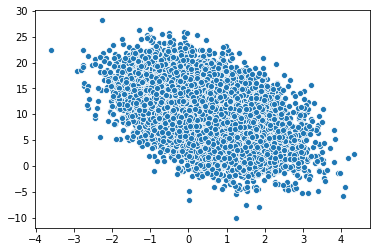

In [25]:
sns.scatterplot(x=X, y=y)

In [27]:
def ols(x, y):
    denom = np.mean((x - np.mean(x))**2)
    nomi = np.cov(X, y)[1, 0]
    return nomi/denom

In [28]:
#  ordinary least squares
print("単純にXでyを回帰すると", ols(X, y))
print("交絡要因を取り除いてあげると、", ols(X, y - 6*u))

単純にXでyを回帰すると -2.249917301523579
交絡要因を取り除いてあげると、 1.997859915706129


(OLS:重回帰分析を実施する。)

Text(0.5, 0, 'Explainary variable')

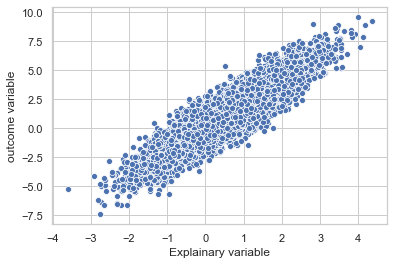

In [65]:
g = sns.scatterplot(x=X, y=y-6*u, )
g.set_ylabel("outcome variable")
g.set_xlabel("Explainary variable")

Text(0.5, 0, 'Explainary variable')

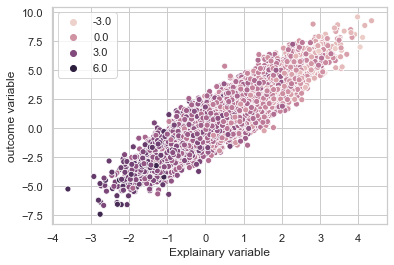

In [66]:
g = sns.scatterplot(x=X, y=y-6*u, hue=u)
g.set_ylabel("outcome variable")
g.set_xlabel("Explainary variable")

- ただ現実では、交絡Uは観測できないケースが多い&経済活動などの観察データでは、多数の交絡があることが予想される。
- そこで交絡調整を必要としない、「あるいくつかの仮定」を満たす操作変数というものを利用して推定する方法を試してみる。

In [30]:
def IV(x, y, z):
    denom = np.cov(X, z)[1, 0]
    nomi = np.cov(z, y)[1, 0]
    return nomi/denom

In [31]:
print("操作変数法を用いて推定した時の因果効果", IV(X, y, Z))

操作変数法を用いて推定した時の因果効果 1.9331223170128733


In [32]:
print("交絡要因を取り除いてあげて推定した因果効果、", ols(X, y - 6*u))

交絡要因を取り除いてあげて推定した因果効果、 1.997859915706129


## OLS推定量ではマイナスになっていたが、IV法を利用すると真のモデルと整合的な推定値を求めることができた。

- U関係なく動くZの変動を利用し、Zと相関するXの変動からYの変動を説明するということ。
- IVの式を確認すると、$\displaystyle \frac{Cov(Z, Y)}{Cov(Z, X)}$となっていることがわかる。

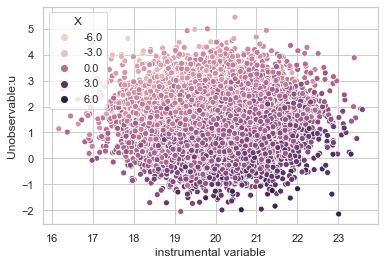

In [51]:
g = sns.scatterplot(x=Z, y=u, hue=X)
g.set_ylabel("Unobservable:u")
g.set_xlabel("instrumentaal variable")
g.legend(title="X")

# 操作変数で不偏推定量が識別できることはわかった。

- <font color="red">どんな仮定が必要やねん...</font>


1. 除外制約（ Z と　YはXを通して以外の因果関係的な繋がりが無い）
2. 関連性の仮定
3. No heterogeneity in the effect.

再掲！！！
<img src="../img/IV.png">

In [72]:
print("1. 除外制約", np.corrcoef(Z, u)[0, 1])
print("2. 関連性", np.corrcoef(X, Z)[0,1 ])

1. 除外制約 -0.005323769064621541
2. 関連性 0.3909627519369086


なるほどな。
ところで、この推定方法って万能なの？

...No

## Weak Instrumentのケースを紹介する（TBD）

In [75]:
def generate_dataset(cov_xz=0.4):
    Sigma = np.eye(3)
    Sigma[1, 0] = -0.7
    Sigma[0, 1] = -0.7
    Sigma[2, 0] = cov_xz
    Sigma[0, 2] = cov_xz
    d = np.random.multivariate_normal([0.5, 1.5, 20.0], Sigma, size=10000)
    e = np.random.randn(len(d))
    X = d[:, 0]
    u = d[:, 1]
    Z = d[:, 2]
    # 目的変数の真のモデル
    # y = 2 A + 6U + \epsilon
    y = X*2 + 6*u + e
    return X, u, Z, y

In [80]:
a = np.linspace(0, 1, num=101)

In [97]:
ols_result = []
iv_result = []
ols_no_confounding = []
for cov_xz in a:
    X, u, Z, y =  generate_dataset(cov_xz=cov_xz)
    print(cov_xz)
    # 相関関係の確認
    print("Cov(X, u)=", np.corrcoef(X, u)[0, 1])
    print("Cov(Z, u)=", np.corrcoef(Z, u)[0, 1])
    print("Cov(X, Z)=", np.corrcoef(X, Z)[0,1 ])
    ols_res = ols(X, y)
    iv_res = IV(X, y, Z)
    ols_no_c =  ols(X, y - 6*u)
    print("単純にXでyを回帰すると", ols_res)
    print("単純にXでyを回帰すると", iv_res)
    print("交絡要因を取り除いてあげると、",ols_no_c)
    ols_result.append(ols_res)
    ols_result.append(iv_res)
    ols_no_confounding.append(ols_no_c)

0.0
Cov(X, u)= -0.7020507938306344
Cov(Z, u)= 0.01215130578558231
Cov(X, Z)= -0.005008463447476163
単純にXでyを回帰すると -2.1994045857790097
単純にXでyを回帰すると -12.025295013951556
交絡要因を取り除いてあげると、 2.0095722367383884
0.01
Cov(X, u)= -0.7006436032460327
Cov(Z, u)= 0.004770265688849648
Cov(X, Z)= 0.00753266474801102
単純にXでyを回帰すると -2.167065164852479
単純にXでyを回帰すると 7.048974094976522
交絡要因を取り除いてあげると、 1.9993254354011039
0.02
Cov(X, u)= -0.7019628283274558
Cov(Z, u)= 0.0026012476069681035
Cov(X, Z)= 0.01964556867354398
単純にXでyを回帰すると -2.284421329730632
単純にXでyを回帰すると 3.1664588571859262
交絡要因を取り除いてあげると、 1.9832151917568206
0.03
Cov(X, u)= -0.701196356926018
Cov(Z, u)= -0.002488750184560417
Cov(X, Z)= 0.018085624694760827
単純にXでyを回帰すると -2.1855883764134916
単純にXでyを回帰すると 0.35551179686365847
交絡要因を取り除いてあげると、 1.988420861858027
0.04
Cov(X, u)= -0.7060124896655737
Cov(Z, u)= 0.0028562215162979006
Cov(X, Z)= 0.04053873071868622
単純にXでyを回帰すると -2.2312238040483265
単純にXでyを回帰すると 2.445739399585582
交絡要因を取り除いてあげると、 1.9972721192113287
0.05


単純にXでyを回帰すると -1.8494137241170925
単純にXでyを回帰すると 1.8295065017810703
交絡要因を取り除いてあげると、 1.9988852244419777
0.78
Cov(X, u)= -0.6530155643349249
Cov(Z, u)= -0.03799264589586509
Cov(X, Z)= 0.7189743653012518
単純にXでyを回帰すると -1.8587354877622455
単純にXでyを回帰すると 1.7042784155734099
交絡要因を取り除いてあげると、 1.9930886294415981
0.79
Cov(X, u)= -0.628414502326428
Cov(Z, u)= -0.02245892212652176
Cov(X, Z)= 0.7234082798123563
単純にXでyを回帰すると -1.64974743106701
単純にXでyを回帰すると 1.859201446862266
交絡要因を取り除いてあげると、 2.0186338301815883
0.8
Cov(X, u)= -0.6211818313128796
Cov(Z, u)= -0.02297536489551644
Cov(X, Z)= 0.7187281193532679
単純にXでyを回帰すると -1.6613990957868214
単純にXでyを回帰すると 1.792209837340639
交絡要因を取り除いてあげると、 1.9930275946574443
0.81
Cov(X, u)= -0.6205744655245884
Cov(Z, u)= -0.03501926495432426
Cov(X, Z)= 0.7208806918099909
単純にXでyを回帰すると -1.6763137931247019
単純にXでyを回帰すると 1.6802202791098044
交絡要因を取り除いてあげると、 1.975707115451696
0.8200000000000001
Cov(X, u)= -0.615834567114888
Cov(Z, u)= -0.028409464195871544
Cov(X, Z)= 0.7113361779270311
単純に

/Users/junpei.takubo/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


In [92]:
import pandas as pd
result_df = pd.DataFrame({"ols":ols_result, "iv":iv_result, "ols_no_conf":ols_no_confounding})
result_df.set_index(np.linspace(0, 1, num=101))

,ols,iv,ols_no_conf
0.00,-2.160904,-3.366225,2.002892
0.01,-2.147871,9.747810,2.002559
0.02,-2.158664,6.890132,1.999911
0.03,-2.187100,1.326952,2.005567
0.04,-2.179058,2.916723,1.998263
...,...,...,...
0.96,-0.960381,1.281580,1.996814
0.97,-0.827391,1.350303,2.002962
0.98,-0.941398,1.259241,1.996398
0.99,-0.942864,1.288693,2.005909


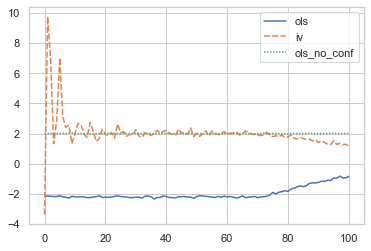

In [93]:
# ols_result
ax = sns.lineplot(data=result_df,)

### weak iv: 関連性が弱すぎると、推定量にbiasがかかる（推定分散も大きくなる）という問題

- Z, Xの相関が弱すぎると推定量の分散が大きくなる上に推定量の不偏性が保証出来なくなる。

[余談]
- Cov(Z, u)を0.7以上大きくすることはこの問題設定上出来ないみたい...(数理統計スキルに難あり)

In [96]:
# 相関関係の確認
print("Cov(X, u)=", np.corrcoef(X, u)[0, 1])
print("Cov(Z, u)=", np.corrcoef(Z, u)[0, 1])
print("Cov(X, Z)=", np.corrcoef(X, Z)[0,1 ])

Cov(X, u)= -0.5053420148357981
Cov(Z, u)= -0.10301557333462447
Cov(X, Z)= 0.6970483513425303


In [ ]:
#  ordinary least squares
print("単純にXでyを回帰すると", ols(X, y))
print("交絡要因を取り除いてあげると、", ols(X, y - 6*u))

## Example

Z: 不妊治療の成功の可否<br>
A: 子供を持つ<br>
Y: キャリア<br>
U:キャリアに関する個人の嗜好<br>

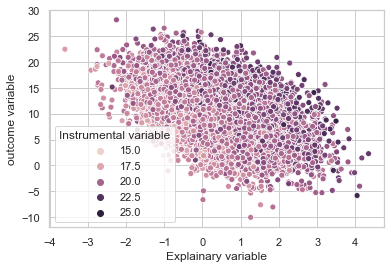

In [52]:
g = sns.scatterplot(x=X, y=y, hue=Z)
g.set_ylabel("outcome variable")
g.set_xlabel("Explainary variable")
g.legend(title="Instrumental variable")

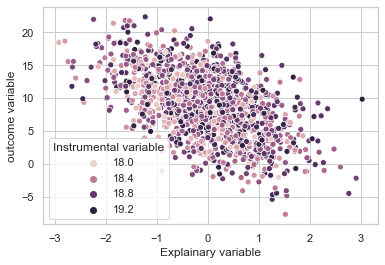

In [63]:
thr =  (18 <Z ) &  (Z < 19)
g = sns.scatterplot(x=X[thr], y=y[thr], hue=Z[thr])
g.set_ylabel("outcome variable")
g.set_xlabel("Explainary variable")
g.legend(title="Instrumental variable")

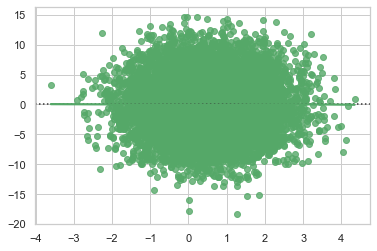

In [42]:
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Make an example dataset with y ~ x
# Plot the residuals after fitting a linear model
g = sns.residplot(X, y, lowess=True, color="g")

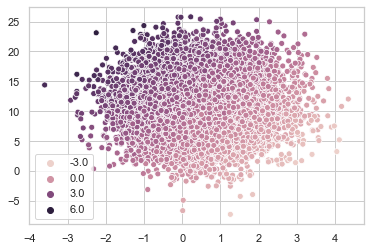

In [46]:
sns.scatterplot(X, y - ols(X,y)*X, hue=u)

u is

- negatively correlated with X
    - 交絡変数が高い値をとるものが、X低い値に集まっている

In [ ]:
# Sigma = np.eye(4)
# Sigma[1, 0] = Sigma[0, 1] = 0.4
# Sigma[2, 0] = Sigma[0, 2] = 0.7
# Sigma[0, 3] = 0.5;Sigma[3, 0] = 0.5;Sigma[1, 3] = 0.5;Sigma[3, 1] = 0.5
# # X, y, IV, U
# data = np.random.multivariate_normal([0.5, 3, 0.5, 0.5], Sigma, size=10000)
# X = data[:, 0]
# y = data[:, 1]
# Z = data[:, 2]
# U = data[:,3]
# y[X>0].mean(), y[X<0].mean()
# np.corrcoef(y, (U> 0)*1, )

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(style="darkgrid")

# tips = sns.load_dataset("tips")
# g = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
# bins = np.linspace(0, 60, 13)
# g.map(sns.scatterplot, "total_bill", color="steelblue", bins=bins)